In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt

from jax.experimental.ode import build_odeint, odeint
import jax.numpy as np
from jax.random import PRNGKey
import numpy as onp

import numpyro
import numpyro.distributions as dist
# from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

NUM_CHAINS = 1
numpyro.set_host_device_count(NUM_CHAINS)
numpyro.enable_x64()

# Data

In [242]:
import pandas as pd

ix = pd.IndexSlice

full = pd.read_csv('full.csv', index_col=['location', 'date', 'variable'], parse_dates=['date']).iloc[:, 0]
populations_country = pd.read_csv('populations_country.csv', index_col='location').iloc[:, 0]

country = 'Italy'
subset = full.loc[country]
deaths_subset = subset.loc[ix[:, 'total_deaths']]

pop_country = populations_country.loc[country]

ten_deaths_date = deaths_subset.gt(10).cumsum().loc[lambda s: s==1].index[0]
begin_date = ten_deaths_date - pd.Timedelta(30, unit='days')

total_deaths = deaths_subset.loc[begin_date:].values
# data = total_deaths / pop_country

times = deaths_subset.loc[begin_date:].index.map(onp.datetime64).to_numpy()

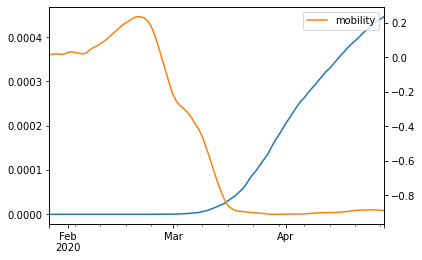

In [257]:
mobility = subset.loc[ix[:, 'transit']].rename('mobility')
mobility = mobility.reindex(deaths_subset.loc[begin_date:].index).fillna(mobility.iloc[-1]).rolling('7d').mean()

to_plot = pd.DataFrame({'deaths': total_deaths / pop_country}, index=times).join(mobility)
to_plot['deaths'].plot(label='deaths')
to_plot['mobility'].plot(secondary_y=True)
plt.legend() ;

In [258]:
mobility

date
2020-01-27    0.016000
2020-01-28    0.017750
2020-01-29    0.020133
2020-01-30    0.017100
2020-01-31    0.017540
                ...   
2020-04-24   -0.884271
2020-04-25   -0.883800
2020-04-26   -0.884443
2020-04-27   -0.886043
2020-04-28   -0.887514
Name: mobility, Length: 93, dtype: float64

# SEIR-HCD

## Parameters used in the model

R_t = reproduction number at time t. Typical 3.6* at t=0

Transition times

    T_inc = average incubation period. Typical 5.6* days
    T_inf = average infectious period. Typical 2.9 days
    T_hosp = average time a patient is in hospital before either recovering or becoming critical. Typical 4 days
    T_crit = average time a patient is in a critical state (either recover or die). Typical 14 days

Fractions  
These constants are likely to be age specific (hence the subscript a):

    m_a = fraction of infections that are asymptomatic or mild. Assumed 80% (i.e. 20% severe)
    c_a = fraction of severe cases that turn critical. Assumed 10%
    f_a = fraction of critical cases that are fatal. Assumed 30%
    
*Averages taken from https://www.kaggle.com/covid-19-contributions

## Model

In [252]:
%%latex
\begin{align}
\frac{dS}{dt} &= - \frac{R_t}{T_{inf}} I S \\
\frac{dE}{dt} &= \frac{R_t}{T_{inf}} I S - \frac{E}{T_{inc}} \\
\frac{dI}{dt} &= \frac{E}{T_{inc}} - \frac{I}{T_{inf}} \\
\frac{dR}{dt} &= m_a \frac{I}{T_{inf}} + (1 - c_a)\frac{H}{T_{hosp}} \\
\frac{dH}{dt} &= (1 - m_a) \frac{I}{T_{inf}} + (1 - f_a)\frac{C}{T_{crit}} - \frac{H}{T_{hosp}} \\
\frac{dC}{dt} &= c_a \frac{H}{T_{hosp}} - \frac{C}{T_{crit}} \\
\frac{dD}{dt} &= f_a \frac{C}{T_{crit}}
\end{align}

<IPython.core.display.Latex object>

In [266]:
mobility_data = np.asarray(mobility.to_numpy())

def dz_dt(z, t, r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a):
#     s = np.clip(z[0], 0., 1.)
#     e = np.clip(z[1], 0., 1.)
#     i = np.clip(z[2], 0., 1.)
#     r = np.clip(z[3], 0., 1.)
#     h = np.clip(z[4], 0., 1.)
#     c = np.clip(z[5], 0., 1.)
#     d = np.clip(z[6], 0., 1.)
    s = z[0]
    e = z[1]
    i = z[2]
    r = z[3]
    h = z[4]
    c = z[5]
#     d = z[6]
    
#     # equivalent to rt = r0 if t < t_lim else r1
#     bl = t < t_lim
#     rt = r0 * bl + (1 - bl) * r1
    int_t = np.array([t]).astype(int)[0]
    rt = r0 * (1 + mobility_data[int_t]) - r1 * mobility_data[int_t]
    
    ds = - (rt / t_inf) * i * s
    de = (rt / t_inf) * i * s - (e / t_inc)
    di = e / t_inc - i / t_inf
    dr = m_a * i / t_inf + (1 - c_a) * (h / t_hosp)
    dh = (1 - m_a) * (i / t_inf) + (1 - f_a) * c / t_crit - h / t_hosp
    dc = c_a * h / t_hosp - c / t_crit
    dd = f_a * c / t_crit
    
    return np.stack([ds, de, di, dr, dh, dc, dd])

seirhcd_int = build_odeint(dz_dt, rtol=1e-5, atol=1e-9, mxstep=500)

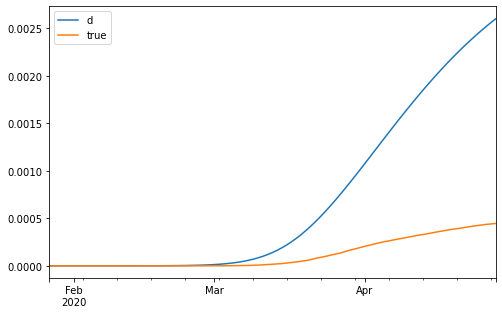

In [261]:
n_inf = 1000 / pop_country
z_init = np.array([1. - n_inf, 0., n_inf, 0., 0., 0., 0.])
ts = np.arange(float(data.shape[0]))

# original parameters
R_0 = 3.3
R_1 = 0.8
t_lim = 30.
t_inc = 5.6
t_inf = 2.9
t_hosp = 4.
t_crit = 14.
m_a = 0.8
c_a = 0.1
f_a = 0.35

# # inferred parameters
# R_0 = 3.98
# R_1 = 0.62
# t_lim = 28.5
# t_inc = 3.77
# t_inf = 5.42
# t_hosp = 3.94
# t_crit = 22.85
# m_a = 0.77
# c_a = 0.2
# f_a = 0.44

args = (R_0, R_1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)

res = seirhcd_int(z_init, ts, *args)
df_res = pd.DataFrame(res)
df_res.columns = 's e i r h c d'.split()

fig, ax = plt.subplots()
df_res.set_index(times)['d'].plot(figsize=(8, 5), ax=ax) ;
pd.DataFrame({'true': total_deaths / pop_country}).set_index(times).plot(ax=ax)
plt.legend() ;

In [267]:
def reparametrize_beta(u, v):
#     v = numpyro.sample(f'sample_size_{i}', dist.Exponential(1.))
    return u*v, (1-u)*v

def reparametrize_gamma(mean, std):
    var = std ** 2
    alpha = mean ** 2 / var
    beta = mean / var
    return alpha, beta

def model(N, y=None):
    i_init = numpyro.sample('i_init', dist.TruncatedNormal(loc=50., scale=10.)) / pop_country
    z_init = np.array([1. - i_init, 0., i_init, 0., 0., 0., 0.])
    ts = np.arange(float(N))
    
    kappa0 = numpyro.sample('kappa0', dist.TruncatedNormal(0, 0., 0.5))
    kappa1 = numpyro.sample('kappa1', dist.TruncatedNormal(0, 0, 0.5))
    r0 = numpyro.sample('r0', dist.TruncatedNormal(0, 3.28, kappa0))
    r1 = numpyro.sample('r1', dist.TruncatedNormal(0., 0.7, kappa1))
    
#     t_delta = numpyro.sample('t_delta', dist.Gamma(*reparametrize_gamma(3., 1.)))
#     t_delta = int(np.floor(t_delta))
    
    t_inc = numpyro.sample('t_inc', dist.Gamma(*reparametrize_gamma(5.6, .86)))
    t_inf = numpyro.sample('t_inf', dist.Gamma(*reparametrize_gamma(2.9, 1.)))
    t_hosp = numpyro.sample('t_hosp', dist.Gamma(*reparametrize_gamma(4., 1.)))
    t_crit = numpyro.sample('t_crit', dist.Gamma(*reparametrize_gamma(14., 1.)))
    
    sample_size = numpyro.sample('sample_size', dist.Exponential(1.0))
    m_a = numpyro.sample('m_a', dist.Beta(*reparametrize_beta(0.8, sample_size)))
    c_a = numpyro.sample('c_a', dist.Beta(*reparametrize_beta(0.1, sample_size)))
    f_a = numpyro.sample('f_a', dist.Beta(*reparametrize_beta(0.35, sample_size)))
    
    params = (r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)
    
    z = seirhcd_int(z_init, ts, *params)
    
    total_deaths = z[:, -1]
    daily_deaths = np.hstack((np.array([0.]), np.diff(total_deaths * pop_country))) + 1

    psi = numpyro.sample('psi', dist.TruncatedNormal(scale=5.))
    
    numpyro.sample('y', dist.GammaPoisson(psi * daily_deaths, rate=psi), obs=y)

In [268]:
data = np.hstack((np.array([0.]), np.diff(total_deaths)))

# use dense_mass for better mixing rate
mcmc = MCMC(NUTS(model, dense_mass=True),
            100, 100, num_chains=NUM_CHAINS,
            progress_bar=True)
mcmc.run(PRNGKey(0), N=data.shape[0], y=data.astype(int))
mcmc.print_summary()

sample: 100%|██████████| 200/200 [06:27<00:00,  1.94s/it, 1023 steps of size 7.81e-03. acc. prob=0.79]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.14      0.13      0.10      0.00      0.33      7.47      1.20
          f_a      0.24      0.20      0.19      0.00      0.61     19.42      0.99
       i_init     47.38      7.53     46.78     36.75     61.05    127.40      0.99
       kappa0      0.49      0.31      0.42      0.03      0.91     23.16      1.18
       kappa1      0.36      0.28      0.30      0.01      0.76     28.49      0.99
          m_a      0.80      0.25      0.90      0.34      1.00     10.73      1.33
          psi      0.09      0.02      0.09      0.06      0.12     54.98      1.01
           r0      3.78      0.46      3.72      3.03      4.38     38.61      1.16
           r1      0.87      0.41      0.73      0.26      1.48     16.78      1.03
  sample_size      2.06      1.27      1.58      0.47      3.95     51.18      0.99
       t_crit     13.94      0.83     13.87     12.74     15.43    120.58  

In [182]:
times[41]

numpy.datetime64('2020-03-08T00:00:00.000000000')

In [269]:
y_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])['y']

pop_pred = y_pred
mu = np.mean(pop_pred, 0)
pi = np.percentile(pop_pred.astype(float), (10., 90.), 0)

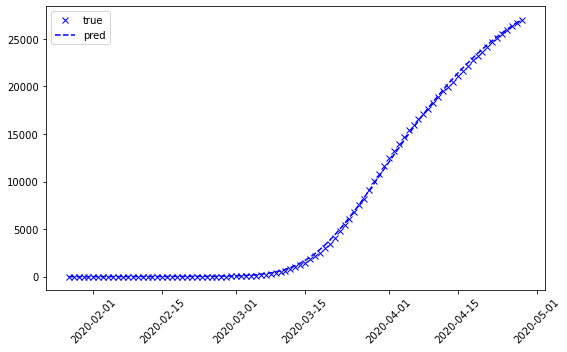

In [276]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.plot(times, np.cumsum(data), "bx", label="true")
plt.plot(times, np.cumsum(mu), "b--", label="pred")
# plt.fill_between(times, pi[0, :], pi[1, :], color="b", alpha=0.3)
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()

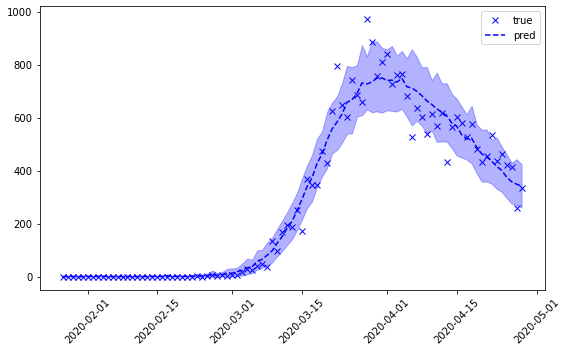

In [277]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.plot(times, data, "bx", label="true")
plt.plot(times, mu, "b--", label="pred")
plt.fill_between(times, pi[0, :], pi[1, :], color="b", alpha=0.3)
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()

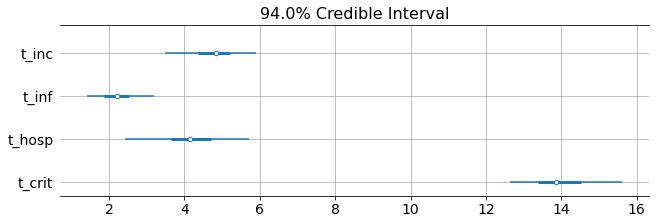

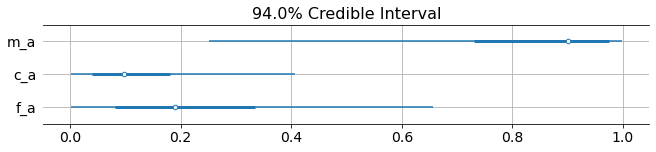

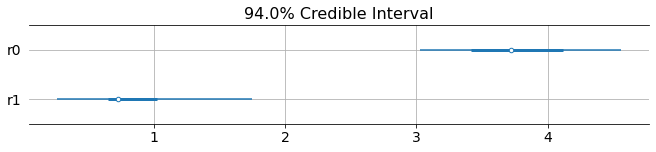

In [278]:
az.plot_forest(inference_data, var_names=['t_inc', 't_inf', 't_hosp', 't_crit'], kind='forestplot', ridgeplot_overlap=3, combined=True, figsize=(9, 3))
plt.grid()
az.plot_forest(inference_data, var_names=['m_a', 'c_a', 'f_a'], figsize=(9, 2))
plt.grid()
az.plot_forest(inference_data, var_names=['r0', 'r1'], figsize=(9, 2))
plt.grid()
# az.plot_forest(inference_data, var_names=['t_lim'], figsize=(9, 1))

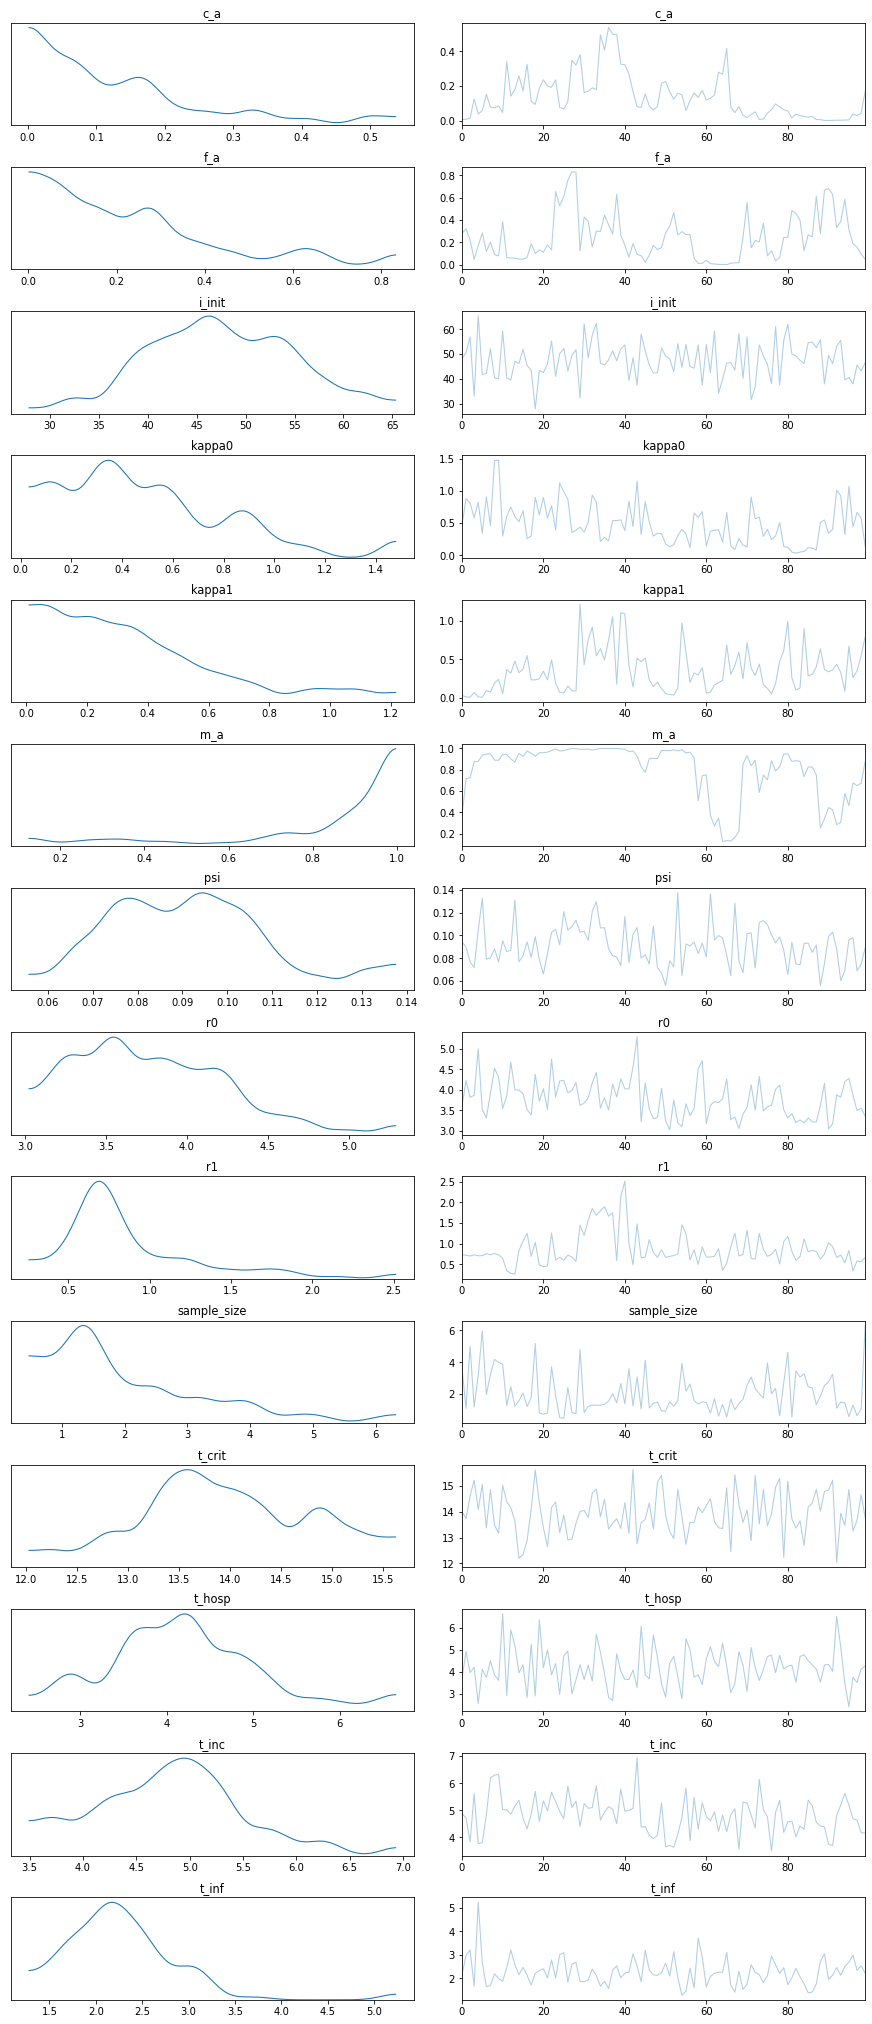

In [279]:
inference_data = az.from_numpyro(mcmc)

az.plot_trace(inference_data) ;

# Misc

In [100]:
daily_deaths = np.array([0, 0, 1, 2, 3, 5]) + 1

for i in range(100):
    with numpyro.handlers.seed(rng_seed=i):
        psi = numpyro.sample('psi', dist.TruncatedNormal(scale=5.))
#         print(f'{psi=}')
        gp_sample = numpyro.sample('y', dist.GammaPoisson(psi * daily_deaths, rate=psi))
#         print(gp_sample)
        beta_sample = numpyro.sample('m_a', dist.Beta(*reparametrize_beta(0.8, numpyro.sample('sample_size', dist.Exponential(1.0)))))
#         print(beta_sample)

# SI model
Inspired by the predator-prey tutorial and the PYMC3 ode blog post

We use first a SI model, of two populations:
- Susceptible (S)
- Infected (I)

The dynamics of populations is governed by a system of differential equations:
- $\frac{dS}{dt} = - R_0 S I$
- $\frac{dI}{dt} = R_0 S I$